In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.utils as vutils
import matplotlib.pyplot as plt

from discriminator import Discriminator
from generator import Generator

from torch.utils.data import DataLoader, Dataset


from utils import *
import torchvision
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:

def visualize(dataloader, netG, netD, criterion, epoch, fixed_noise, device):
    for real_batch in dataloader:
        break
    y_labels = real_batch[1].to(device)
    real_batch = real_batch[0].to(device)
    
    batch_size = real_batch.size(0)
    label = torch.full((batch_size,), 1.0, device=device)
    output = netD(real_batch).view(-1)
    errD_real = criterion(output, label)
    D_x = output.mean().item()

    fake = netG(fixed_noise)
    label.fill_(0.0)
    output = netD(fake.detach()).view(-1)
    errD_fake = criterion(output, label)
    D_G_z1 = output.mean().item()

    errD = errD_real + errD_fake

    label.fill_(1.0)
    output = netD(fake).view(-1)
    errG = criterion(output, label)
    D_G_z2 = output.mean().item()

    print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
          % (epoch, 100, 0, len(dataloader),
             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    

    fake = netG(fixed_noise)
    

    # Plot the fake images from the last epoch

    fake = (fake - fake.min())/ (fake.max() - fake.min())
    # for row in range(8):
    #     for col in range(8):
    #         plt.subplot(8, 8, row*8+col+1)
    #         plt.axis("off")
    #         # set subplot label to be the label of the image
    #         plt.title(y_labels[row*8+col].item())
    #         # make title fit properly
    #         plt.subplots_adjust(top=1.5)
    #         # correct for mean 0 and std 1
    #         # unnormalize
    #         # adjust to 0 to 1 range
    #         plt.imshow(fake[row*8+col].detach().cpu().numpy().transpose(1,2,0), cmap='gray')

    return fake

In [3]:

IMG_SIZE = 128
BATCH_SIZE = 64
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
img_list = []
import glob
for checkpointD, checkpointG in sorted(list(zip(glob.glob("/ssd_scratch/cvit/anirudhkaushik/checkpoints/lsun_ganD_checkpoint_*.pt"),glob.glob("/ssd_scratch/cvit/anirudhkaushik/checkpoints/lsun_ganG_checkpoint_*.pt")))):
    print("epoch :" + checkpointD.split("_")[-2].split(".")[0])
    
    checkpointD = torch.load(checkpointD)
    checkpointG = torch.load(checkpointG)
    modelG = Generator(IMG_SIZE=IMG_SIZE, img_ch=3)
    modelD = Discriminator(img_channels=3, IMG_SIZE=IMG_SIZE)

    modelD = torch.nn.DataParallel(modelD)
    modelG = torch.nn.DataParallel(modelG)


    modelG.module.load_state_dict(checkpointG['model'])
    modelD.module.load_state_dict(checkpointD['model'])

    modelG = modelG.to(device)
    modelD = modelD.to(device)



    data_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])

    ])

    dataset = torchvision.datasets.ImageFolder(root="/ssd_scratch/cvit/anirudhkaushik/datasets/lsun_bedroom/data0/lsun/bedroom", transform=data_transforms)
    data_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)


    # visualize
    criterion = nn.BCELoss()

    fake = visualize(data_loader, modelG, modelD, criterion, 0, fixed_noise, device)
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))


epoch :0
[0/100][0/4737] Loss_D: 3.3237 Loss_G: 0.1298 D(x): 0.9395 D(G(z)): 0.8944 / 0.8944
epoch :1
[0/100][0/4737] Loss_D: 1.2975 Loss_G: 2.3810 D(x): 0.4644 D(G(z)): 0.1494 / 0.1494
epoch :2
[0/100][0/4737] Loss_D: 0.0343 Loss_G: 11.3578 D(x): 0.9675 D(G(z)): 0.0001 / 0.0001
epoch :3
[0/100][0/4737] Loss_D: 0.1189 Loss_G: 10.5120 D(x): 0.8990 D(G(z)): 0.0001 / 0.0001
epoch :checkpoint
[0/100][0/4737] Loss_D: 0.1630 Loss_G: 3.5321 D(x): 0.9230 D(G(z)): 0.0657 / 0.0657


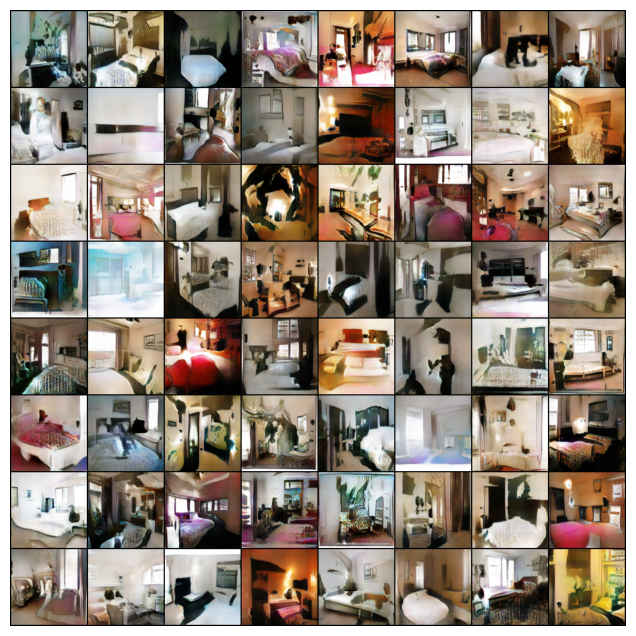

In [4]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
for i in range(len(img_list)):
    img_list[i] = img_list[i].cpu().detach().numpy()
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

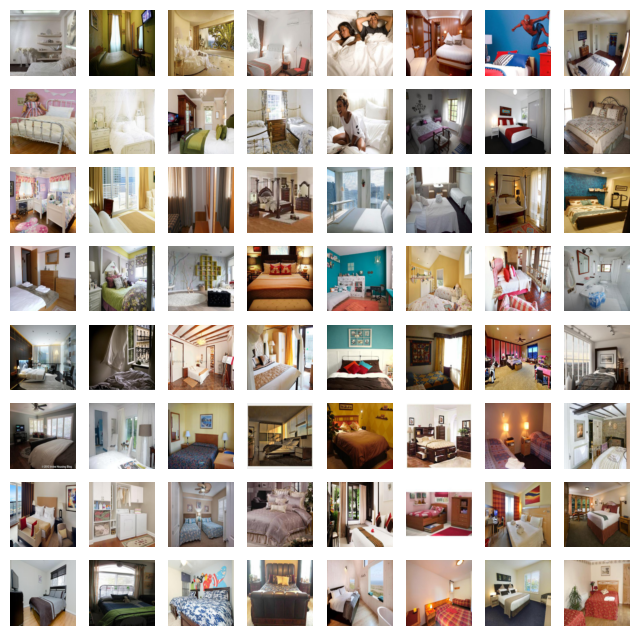

In [5]:
real_batch = next(iter(data_loader))
real_batch = real_batch[0].numpy().transpose(0, 2,3,1)
real_batch = real_batch/2 + 0.5
plt.figure(figsize=(8,8))
plt.clf()
for row in range(8):
    for col in range(8):
        plt.subplot(8, 8, row*8+col+1)
        plt.axis("off")

        plt.imshow(real_batch[row*8+col])
plt.show()
